## Pathway and Cell-Type Enrichment Analysis of Fetal-specific eGenes

In [1]:
options(stringsAsFactors = F)
setwd("~/Github/Fetal_metaQTL/")

library(tidyverse)
#BiocManager::install('gprofiler2')
library(gprofiler2)
library(openxlsx)

source("code/06-analyses/fisher_overlap.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



1. Load data from Table S1

In [11]:
tableS1 = openxlsx::read.xlsx("data/manuscript/ST1.xlsx",sheet="ST1-2-eGene")
dim(tableS1)
fetal_only_eGenes = tableS1 %>% filter(fetal_only=="yes") %>% select(pid, gene_name, gene_type, qval) %>% as_tibble()
fetal_all_eGenes = tableS1 %>% select(pid) %>% pull()
head(fetal_only_eGenes)
dim(fetal_only_eGenes)

[1] 10094    17

pid,gene_name,gene_type,qval
<chr>,<chr>,<chr>,<dbl>
ENSG00000000419,DPM1,protein_coding,0.00147123
ENSG00000002746,HECW1,protein_coding,0.00100023
ENSG00000004478,FKBP4,protein_coding,0.01215830
ENSG00000005812,FBXL3,protein_coding,0.04243070
ENSG00000006025,OSBPL7,protein_coding,0.02392810
ENSG00000006062,MAP3K14,protein_coding,0.01218350


[1] 2488    4

In [9]:
library(gprofiler2)

## Pathway analysis with gProfileR
## Note: ordered query here because genes are ranked by DTU significance. Usually this will be F
## Always use the matching background gene set
path = gprofiler2::gost(query=fetal_only_eGenes$pid,correction_method = 'fdr',
                        custom_bg = fetal_all_eGenes)


Detected custom background input, domain scope is set to 'custom'



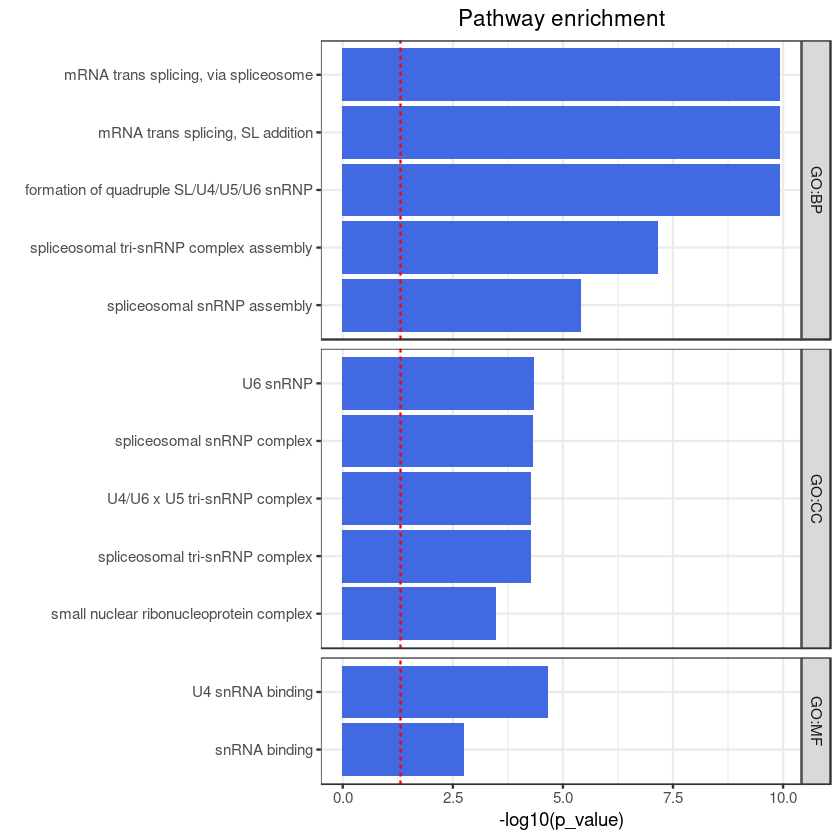

In [10]:
df_path = as_tibble(path$result)

## Plot top 5 results per database
panelA <- df_path %>% group_by(source) %>% slice_min(p_value,n=5) %>% ungroup() %>%
  ggplot(aes(x=reorder(term_name, -p_value), y=-log10(p_value), fill=source)) + geom_bar(stat='identity',fill='royalblue') + coord_flip() + theme_bw() + labs(x="")  + 
  facet_grid(source~., space = 'free', scales='free') + theme(legend.position = 'none') + 
geom_hline(yintercept = -log10(0.05), lty=2,color='red') + ggtitle("Pathway enrichment") + theme(plot.title = element_text(hjust=.5))
panelA


In [57]:
df_path %>% arrange(p_value) %>% head()


query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000353,GO:BP,formation of quadruple SL/U4/U5/U6 snRNP,9958,147,"GO:0022618, GO:0045291"
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000365,GO:BP,"mRNA trans splicing, via spliceosome",9958,149,GO:0000398
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0045291,GO:BP,"mRNA trans splicing, SL addition",9958,13184,GO:0000365
query_1,TRUE,7.226205e-08,35,2389,27,0.011301800,0.7714286,GO:0000244,GO:BP,spliceosomal tri-snRNP complex assembly,9958,110,GO:0000387
query_1,TRUE,4.047260e-06,46,2389,30,0.012557555,0.6521739,GO:0000387,GO:BP,spliceosomal snRNP assembly,9958,161,"GO:0000398, GO:0022618"
query_1,TRUE,2.264497e-05,24,2389,19,0.007953118,0.7916667,GO:0030621,GO:MF,U4 snRNA binding,9958,4916,GO:0017069


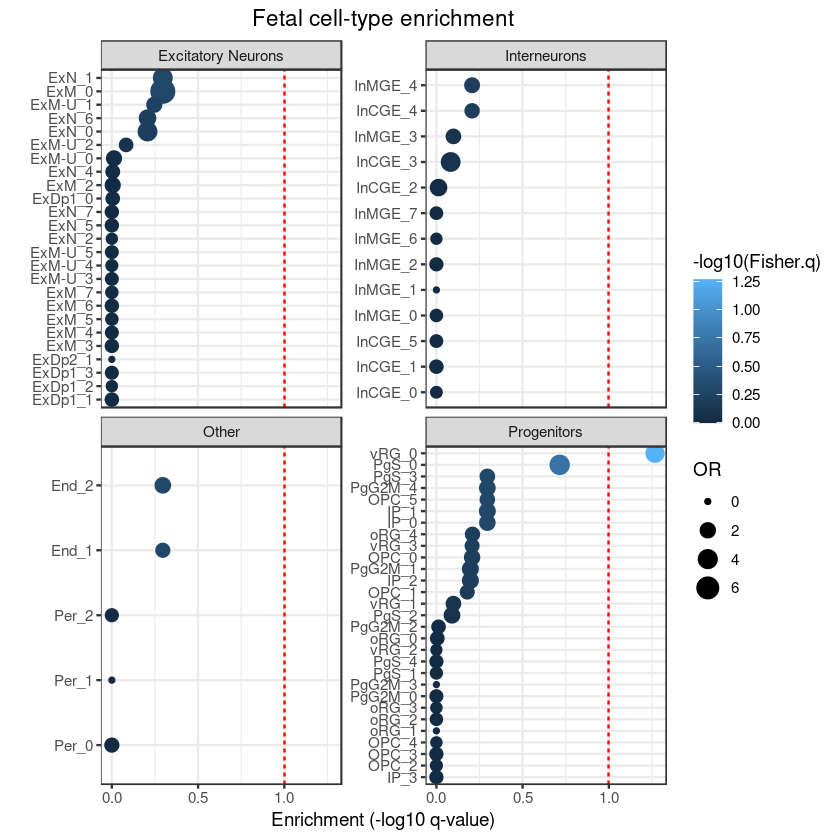

In [13]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()

celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl,celltypemarkers.tableS5$Ensembl))
markers.bg2 <- tableS1 %>% filter(gene_type == "protein_coding") %>%  select(pid) %>% pull()


  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers.tableS5$Subcluster)) {
    marker_genes = celltypemarkers.tableS5 %>% filter(Subcluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(fetal_only_eGenes$pid, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Fetal-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.p[df_fisher$OR<1] = 1
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
panelB <- ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))
panelB
  

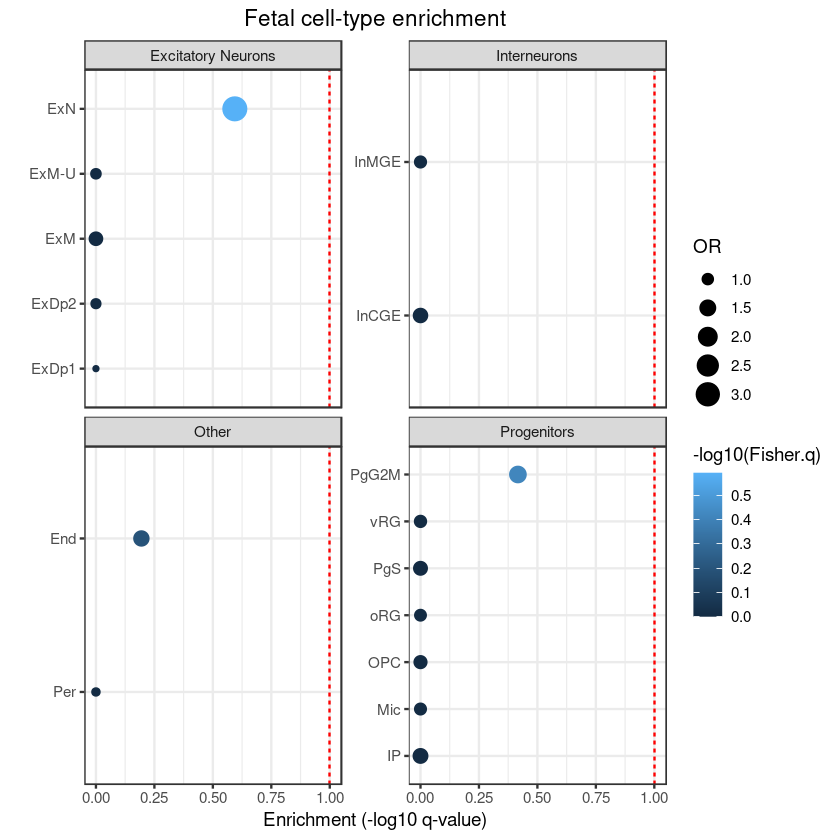

In [14]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()

celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl,celltypemarkers.tableS5$Ensembl))
markers.bg2 <- tableS1 %>% filter(gene_type == "protein_coding") %>%  select(pid) %>% pull()


  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers$Cluster)) {
    marker_genes = celltypemarkers %>% filter(Cluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(fetal_only_eGenes$pid, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Fetal-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.p[df_fisher$OR<1] = 1
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))

  

In [54]:
df_fisher %>% arrange(Fisher.q)

set,cell,OR,Fisher.p,X.95.CI,X.95.CI.1,Overlap,Reference.List,Input.List,Background,X..List.Overlap,Fisher.q,CellClass
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Fetal-only-eGenes,vRG_0,3.297347,0.000915418,1.57129601795046,6.55159304529308,13,43,737,6278,30.2,0.0659101,Other
Fetal-only-eGenes,PgS_0,4.076542,0.005839392,1.37240217300757,11.032189582091,7,20,737,6278,35,0.2102181,Other
Fetal-only-eGenes,PgS_3,1.639604,0.066855735,0.936845210406715,2.73449445469818,19,107,737,6278,17.8,0.5656805,Other
Fetal-only-eGenes,PgG2M_4,2.085499,0.070986923,0.820629188598418,4.69767122220521,8,37,737,6278,21.6,0.5656805,Other
Fetal-only-eGenes,IP_0,2.015658,0.078566733,0.795329694959425,4.52184966580747,8,38,737,6278,21.1,0.5656805,Other
Fetal-only-eGenes,IP_1,2.163534,0.036289564,0.951366277932378,4.48763916773158,10,45,737,6278,22.2,0.5656805,Other
Fetal-only-eGenes,ExN_1,3.776744,0.024146851,1.01002851198311,12.1678088419601,5,15,737,6278,33.3,0.5656805,Excitatory Neurons
Fetal-only-eGenes,ExM_0,7.531572,0.070258530,0.545176261811707,104.073635782812,2,4,737,6278,50,0.5656805,Excitatory Neurons
Fetal-only-eGenes,OPC_5,1.595674,0.062462752,0.940257349587002,2.59301461743001,21,121,737,6278,17.4,0.5656805,Other


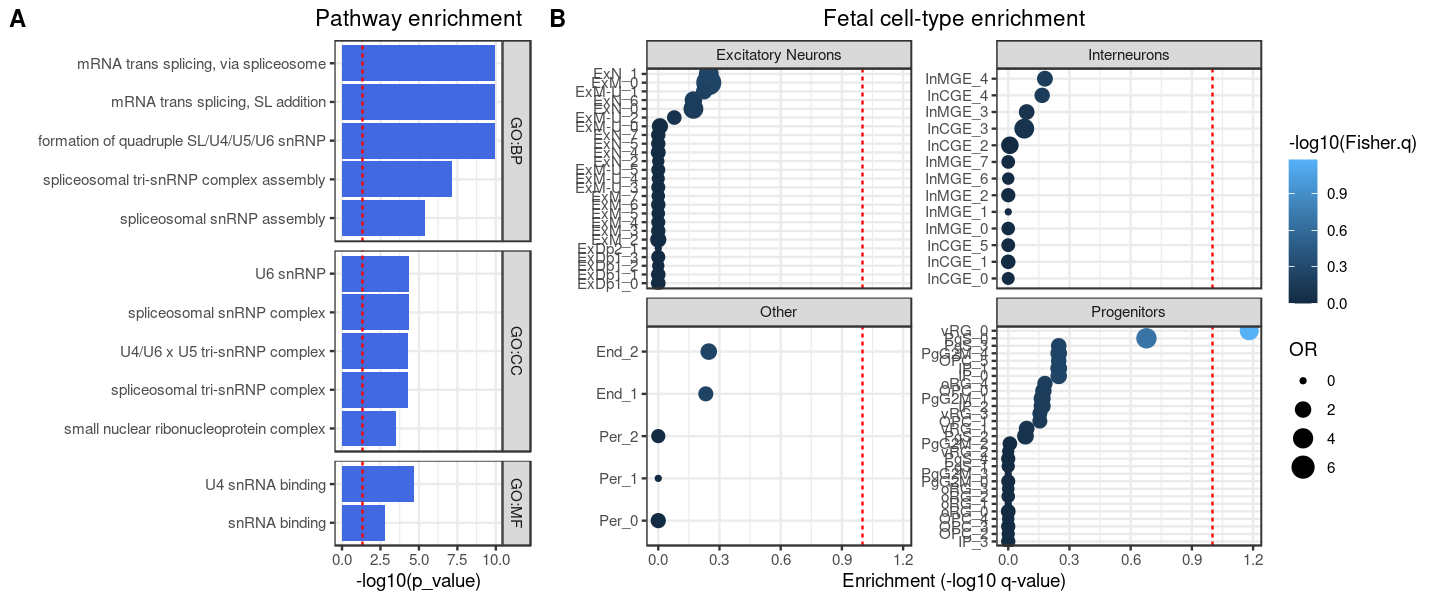

In [86]:
options(repr.plot.width=12, repr.plot.height=5)
cowplot::plot_grid(plotlist = list(panelA, panelB),labels="AUTO",rel_widths = c(.6,1))

In [88]:
openxlsx::read.xlsx("data/manuscript/ST1.xlsx")

,Sheet,Description
,<chr>,<chr>
1,ST1-1-metadata,"Metadata of 654 unique, high-quality samples"
2,ST1-2-eGene,Sum stats of 10094 permutation eGenes and their primary cis-eQTL
3,ST1-3-isoGene,Sum stats of 11845 group permutation isoGenes and their primary cis-isoQTL
4,ST1-4-sGene,Sum stats of 7490 group permutation sGenes and their primary cis-sQTL
5,ST1-5-torus-funcEnrich,Torus functional enrichment of cis-e/iso/sQTL
6,ST1-6-conditional,"Sum stats of conditional cis-eQTL mapping, for detailed descriptions of columns, see https://qtltools.github.io/qtltools/"
7,General Notes,NA
8,TOPMed variants that are not mapped to rsID have hg38 coordinate (chr:pos) as variant ID; actual hg19 coordinates were used in analysis,NA


## Compare Fetal-only-eGenes with Tri1 and Tri2 specific

In [19]:
tableS3.tri1 = openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-1-tri1-eGene") %>% as_tibble()
tableS3.tri1 %>% head()

#4211 tri1 egenes
nrow(tableS3.tri1)


pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000460,6010,1.02748,515.262,91.0303,chr1:169823752,161648,1.87528e-08,-0.338308,9.999e-05,4.91993e-05,4.91144e-04,3.09666e-05
ENSG00000001460,3692,1.04347,626.503,93.7763,rs760969,2280,8.49670e-12,-0.398405,9.999e-05,2.13673e-08,4.57817e-07,2.73383e-05
ENSG00000002016,5008,1.04250,822.961,93.8064,rs2887532,-47724,5.00270e-09,-0.476405,9.999e-05,1.23554e-05,1.44921e-04,2.07242e-05
ENSG00000002549,4608,1.02306,669.967,95.8886,rs10019460,107522,3.33719e-12,-0.485063,9.999e-05,8.09149e-09,1.84090e-07,2.33459e-05
ENSG00000003509,5953,1.02392,880.264,93.4142,rs1158219,88046,4.19471e-09,0.441495,9.999e-05,1.48403e-05,1.70099e-04,1.78380e-05
ENSG00000004534,2064,1.02570,146.024,89.9238,rs1403180440,15338,1.85048e-15,0.363467,9.999e-05,8.49570e-12,3.34591e-10,1.08386e-04


[1] 4211

In [20]:
tableS3.tri2 = openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-2-tri2-eGene") %>% as_tibble()
tableS3.tri2 %>% head()

#2220 tri2 egenes
nrow(tableS3.tri2)

pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000460,6010,1.04653,384.512,101.815,chr1:169823752,161648,9.96853e-09,-0.389951,0.00009999,2.11583e-05,4.70499e-04,2.15440e-05
ENSG00000001460,3692,1.05619,467.377,103.335,rs10903084,3761,1.23423e-15,-0.782329,0.00009999,6.48869e-12,5.56236e-10,1.86000e-05
ENSG00000001630,3216,1.05840,330.091,103.495,rs192531200,-531093,4.23111e-07,-1.766910,0.00019998,4.13634e-04,6.00989e-03,2.66240e-05
ENSG00000002016,5008,1.04679,748.901,106.225,rs12812346,-31035,5.51205e-08,-0.552818,0.00019998,1.10430e-04,1.96400e-03,1.10763e-05
ENSG00000002822,6246,1.03623,831.830,106.168,chr7:3064571,831327,8.78419e-07,-0.572421,0.00149985,1.85745e-03,1.97064e-02,9.45131e-06
ENSG00000003509,5953,1.06228,622.213,101.701,rs1056021,21475,1.16466e-06,0.362884,0.00189981,2.49890e-03,2.50985e-02,1.43969e-05


[1] 2220

In [22]:
#1261 tri1-tri2 shared eGenes
length(intersect(tableS3.tri1$pid, tableS3.tri2$pid))

ORA(fetal_only_eGenes$pid, tableS3.tri1$pid, fetal_all_eGenes, fetal_all_eGenes)

ORA(fetal_only_eGenes$pid, tableS3.tri2$pid, fetal_all_eGenes, fetal_all_eGenes)

[1] 1261

OR               Fisher p                 -95%CI 
   "0.541554618379489" "4.08827237709864e-31"    "0.485651205087775" 
                +95%CI                Overlap         Reference List 
   "0.603251717368026"                  "533"                 "3080" 
            Input List             Background         % List Overlap 
                "2488"                "10094"                 "17.3"

OR               Fisher p                 -95%CI 
   "0.486062037931035" "8.10614848022926e-27"    "0.421071624652551" 
                +95%CI                Overlap         Reference List 
    "0.55948304555766"                  "264"                 "1757" 
            Input List             Background         % List Overlap 
                "2488"                "10094"                   "15"

In [28]:
tri1_only = tableS3.tri1$pid[!tableS3.tri1$pid %in% tableS3.tri2$pid]
length(tri1_only)
tri2_only = tableS3.tri2$pid[!tableS3.tri2$pid %in% tableS3.tri1$pid]
length(tri2_only)

tri1and2_bg = unique(c(tri1_only, tri2_only, tableS1$pid))
length(tri1and2_bg)

[1] 2950

[1] 959

[1] 11630

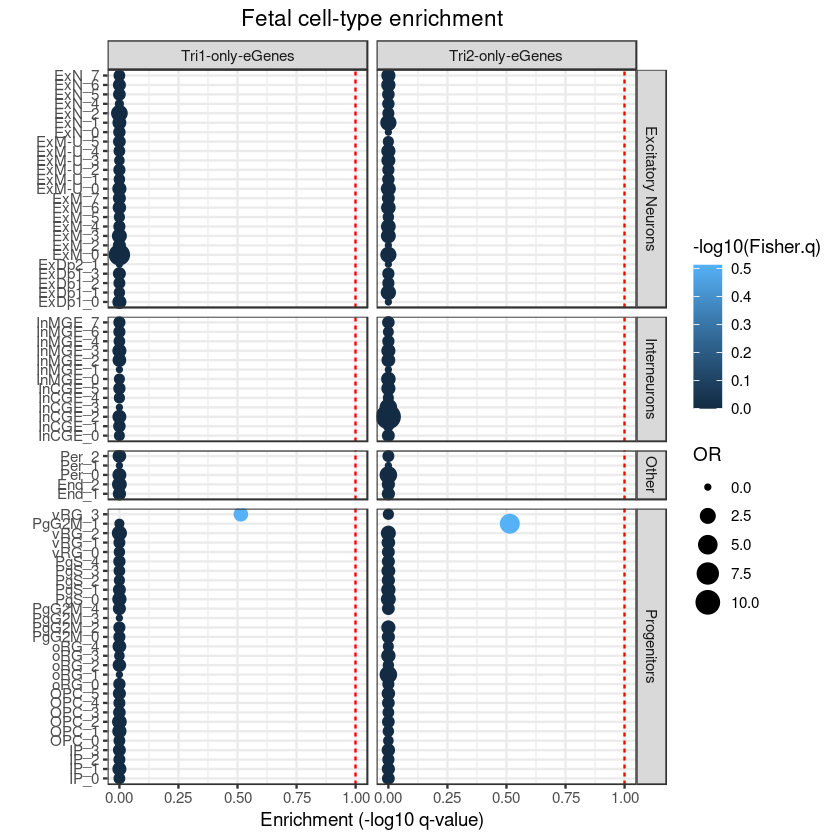

In [34]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()

celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl,celltypemarkers.tableS5$Ensembl))
markers.bg2 <- tableS1 %>% filter(gene_type == "protein_coding") %>%  select(pid) %>% pull()


  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers.tableS5$Subcluster)) {
    marker_genes = celltypemarkers.tableS5 %>% filter(Subcluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(tri1_only, marker_genes, tri1and2_bg, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri1-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
    
      enrichment2 = ORA(tri2_only, marker_genes, tri1and2_bg, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri2-only-eGenes", cell=this_cell, as.data.frame(t(enrichment2))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.p[df_fisher$OR<1] = 1
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_grid(CellClass~set, scales = 'free',space='free') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))

  

In [32]:
df_fisher

set,cell,OR,Fisher.p,X.95.CI,X.95.CI.1,Overlap,Reference.List,Input.List,Background,X..List.Overlap,Fisher.q,CellClass
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Tri1-only-eGenes,ExN,0.9460697,1.00000000,0.279212367701419,2.56526858339441,5,28,400,2142,17.9,1.0000000,Excitatory Neurons
Tri2-only-eGenes,ExN,2.2790195,0.09410333,0.668833813610393,6.22657822288667,5,28,189,2142,17.9,1.0000000,Excitatory Neurons
Tri1-only-eGenes,PgG2M,1.1143410,0.61535736,0.737373291893398,1.64844880289051,36,178,400,2142,20.2,1.0000000,Progenitors
Tri2-only-eGenes,PgG2M,1.3442605,0.26782470,0.778520305607916,2.21647497127874,20,178,189,2142,11.2,1.0000000,Progenitors
Tri1-only-eGenes,OPC,0.8194410,1.00000000,0.530193524898957,1.23232709308179,31,193,400,2142,16.1,1.0000000,Progenitors
Tri2-only-eGenes,OPC,1.4528979,0.11155748,0.871436580166005,2.33100175121208,23,193,189,2142,11.9,1.0000000,Progenitors
Tri1-only-eGenes,End,1.0560498,0.78019769,0.717884207816898,1.52495358931828,41,211,400,2142,19.4,1.0000000,Other
Tri2-only-eGenes,End,0.6548149,1.00000000,0.335417198653141,1.17726357396006,13,211,189,2142,6.16,1.0000000,Other
Tri1-only-eGenes,ExDp2,0.7556156,1.00000000,0.530183125570243,1.05896241686062,47,308,400,2142,15.3,1.0000000,Excitatory Neurons
